In [ ]:
# --- Standard library ---
import ast
from collections import Counter, defaultdict

# --- Third-party libraries ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from tqdm import tqdm

# --- NLP / embeddings ---
from sentence_transformers import SentenceTransformer

# --- Machine learning / clustering ---
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

## 1. Discover Tags

In [119]:
def get_game_codes(archpath="./archive/dataset.csv"):
    gameCodes = set()
    chunksize = 10**5
    for chunk in pd.read_csv(archpath, usecols=["app_id"], chunksize=chunksize):
        gameCodes.update(chunk["app_id"].unique())

    return np.array(list(gameCodes))

gameCodes = get_game_codes()

In [111]:
def get_tags(APPID:int):
    url = f"https://steamspy.com/api.php?request=appdetails&appid={APPID}"

    response = requests.get(url)

    if response.status_code == 200:
        return response.json()['tags']
    else:
        print(f"API fail for {APPID}")

In [120]:
def fetch_and_save_tags(gameCodes, batch_size=500, output_file='output.csv', get_tags_func=None):
    # Load existing tags if CSV exists
    try:
        gameTags = pd.read_csv(output_file)
    except FileNotFoundError:
        gameTags = pd.DataFrame(columns=["APPID", "tags"])
    
    # Filter gameCodes to only new games not already in CSV
    existing_ids = set(gameTags['APPID'].astype(int).tolist())
    gameCodes = [gid for gid in gameCodes if gid not in existing_ids]

    if not gameCodes:
        print("No new games to process.")
        return [], gameTags
    
    # Track games that failed
    nonetags = []

    # Process games in batch
    for i, APPID in tqdm(enumerate(gameCodes), total=len(gameCodes), desc="Fetching tags"):
        if i >= batch_size:
            break
        # Skip APPIDs already in CSV
        if APPID in gameTags['APPID'].values:
            print(f"Skipping {APPID}, already in CSV.")
            continue
        try:
            tags = get_tags_func(APPID)
        except Exception as e:
            print(f"Error fetching tags for {APPID}: {e}")
            nonetags.append(APPID)
            continue
        if tags is not None and tags != []:
            gameTags.loc[len(gameTags)] = [APPID, tags]
        else:
            nonetags.append(APPID)

    # Save updated CSV
    gameTags.to_csv(output_file, index=False)

    print(f"Processed {min(batch_size, len(gameCodes))} games. {len(nonetags)} failed.")
    return nonetags, gameTags

print(gameCodes.shape)
nonetags, gameTags = fetch_and_save_tags(gameCodes, batch_size=500, output_file='output.csv', get_tags_func=get_tags)

(9972,)


Fetching tags: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Processed 10 games. 10 failed.


## 2. Load Tags

In [121]:
def get_tag_stats_from_df(df, tag):
    votes = df.loc[df['tag'] == tag, 'votes'].sum()
    count = df.loc[df['tag'] == tag, 'occurrences'].sum()
    return votes, count

def top_k_by_votes(df, k):
    return df.sort_values(by='votes', ascending=False).head(k)

def top_k_by_count(df, k):
    return df.sort_values(by='occurrences', ascending=False).head(k)

In [153]:
def load_tag_data(tagPath="tags.csv", top_k=446, tagReport=True):
    df = pd.read_csv(tagPath)

    # Convert 'tags' string into actual dictionary
    df['tags_dict'] = df['tags'].apply(ast.literal_eval)

    # Count total votes and occurrences per tag
    vote_counts = Counter()
    occurrence_counts = Counter()
    for tags in df['tags_dict']:
        vote_counts.update(tags)
        occurrence_counts.update(tags.keys())

    # DataFrame with tag stats
    tagCountsDF = pd.DataFrame({
        'tag': [t.lower() for t in vote_counts.keys()],
        'votes': vote_counts.values(),
        'occurrences': [occurrence_counts[tag] for tag in vote_counts.keys()]
    }).sort_values(by='occurrences', ascending=False)

    # List of top_k tags
    tags = tagCountsDF.head(top_k)['tag'].tolist()

    # DataFrame with tags per game filtered by top_k
    tagGamesDF = df[['APPID']].copy()
    tagGamesDF['tags'] = df['tags_dict'].apply(lambda tags: [tag.lower() for tag in tags if tag in tags])

    def tag_report(tagCountsDF, tagGamesDF):
        notags = tagGamesDF.loc[tagGamesDF['tags'].apply(len) == 0, 'APPID'].tolist()

        print("===== TAG REPORT =====")
        print(f"Total unique tags: {len(tagCountsDF)}")
        print(f"Total games: {tagGamesDF['APPID'].nunique()}")
        print(f"Total tags assigned across all games: {sum(tagCountsDF['occurrences'])}")
        print(f"Average tags per game: {tagGamesDF['tags'].apply(len).mean():.2f}")
        print(f"Apps with no tags: {len(notags)}")
        print(f"List of games with no tags: {notags}")
        print("\nTop 1 tags by votes:")
        print(tagCountsDF.head(1))
        print("\nTop 1 tags by occurrences:")
        print(tagCountsDF.sort_values(by='occurrences', ascending=False).head(1))

    if tagReport:
        tag_report(tagCountsDF, tagGamesDF)

    return tagCountsDF, tagGamesDF

tagCountsDF, tagGamesDF = load_tag_data(tagPath=("output.csv"))
tagCountsDF.to_csv("comp/tagCountsDF.csv", index=False)
tagGamesDF.to_csv("comp/tagGamesDF.csv", index=False)


===== TAG REPORT =====
Total unique tags: 446
Total games: 9962
Total tags assigned across all games: 110642
Average tags per game: 11.11
Apps with no tags: 0
List of games with no tags: []

Top 1 tags by votes:
      tag   votes  occurrences
24  indie  547414         6304

Top 1 tags by occurrences:
      tag   votes  occurrences
24  indie  547414         6304


In [154]:
def filter_rare_tags_by_game(tagGamesDF, tagCountsDF, min_count=1, max_count=7000):
    tags_df = tagGamesDF.copy()
    # Keep tags within the occurrence thresholds
    allowed_tags = set(tagCountsDF.loc[
        (tagCountsDF['occurrences'] >= min_count) & (tagCountsDF['occurrences'] <= max_count),
        'tag'
    ])
    
    # Filter tags per game
    tags_df['tags'] = tags_df['tags'].apply(lambda lst: [tag for tag in lst if tag in allowed_tags])
    
    # Drop games with no tags left
    tags_df = tags_df[tags_df['tags'].map(len) > 0].reset_index(drop=True)
    
    return tags_df

filter_rare_tags_by_game(tagGamesDF, tagCountsDF)

,APPID,tags
0,10,"[action, fps, multiplayer, shooter, classic, t..."
1,1002,"[2d fighter, martial arts, intentionally awkwa..."
2,100400,"[animation & modeling, software]"
3,10090,"[zombies, world war ii, fps, multiplayer, acti..."
4,100980,"[animation & modeling, utilities, design & ill..."
...,...,...
9957,99810,"[fps, action, comedy, gore, shooter, singlepla..."
9958,99830,"[action, fps, sci-fi, shooter, singleplayer, m..."
9959,9990,"[adventure, action, local co-op]"
9960,99900,"[free to play, massively multiplayer, rpg, adv..."


## 3.   Visualisations
### 3.1 Tag Distribution

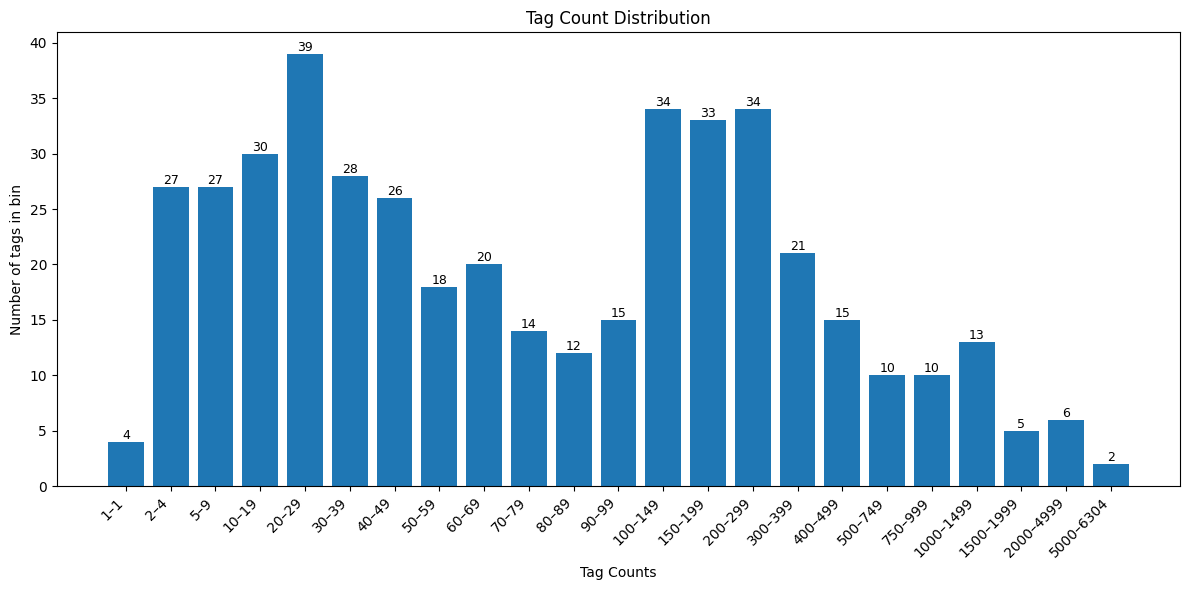

In [155]:
def visualize_tag_distribution_bins(tagCountsDF, bin_mode="auto", title="Tag Count Distribution"):
    counts = tagCountsDF['occurrences'].values

    # Define bins based on mode
    if bin_mode == "per_25":
        bins = list(range(0, max(counts)+25, 25))
    elif bin_mode == "per_50":
        bins = [0, 1, 2, 5, 10, 20]
        step = 50
        while bins[-1] < max(counts):
            bins.append(bins[-1] + step)
    else:  # auto
        bins = bins = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 5000, max(counts)+1]

    bins = sorted(list(set(bins)))
    bin_labels = [f"{bins[i]}–{bins[i+1]-1}" for i in range(len(bins)-1)]

    # Digitize data into bins
    bin_indices = np.digitize(counts, bins, right=True) - 1
    binned = np.array([np.sum(bin_indices == i) for i in range(len(bins)-1)])

    # Remove empty bins
    nonzero_idx = binned > 0
    binned = binned[nonzero_idx]
    bin_labels = np.array(bin_labels)[nonzero_idx]

    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(bin_labels, binned)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of tags in bin")
    plt.xlabel("Tag Counts")
    plt.title(title)
    plt.tight_layout()

    # Add values on top of bars
    for bar, value in zip(bars, binned):
        plt.text(bar.get_x() + bar.get_width()/2, value, f"{int(value)}",
                 ha='center', va='bottom', fontsize=9)

    plt.show()

visualize_tag_distribution_bins(tagCountsDF, bin_mode="auto", title="Tag Count Distribution")

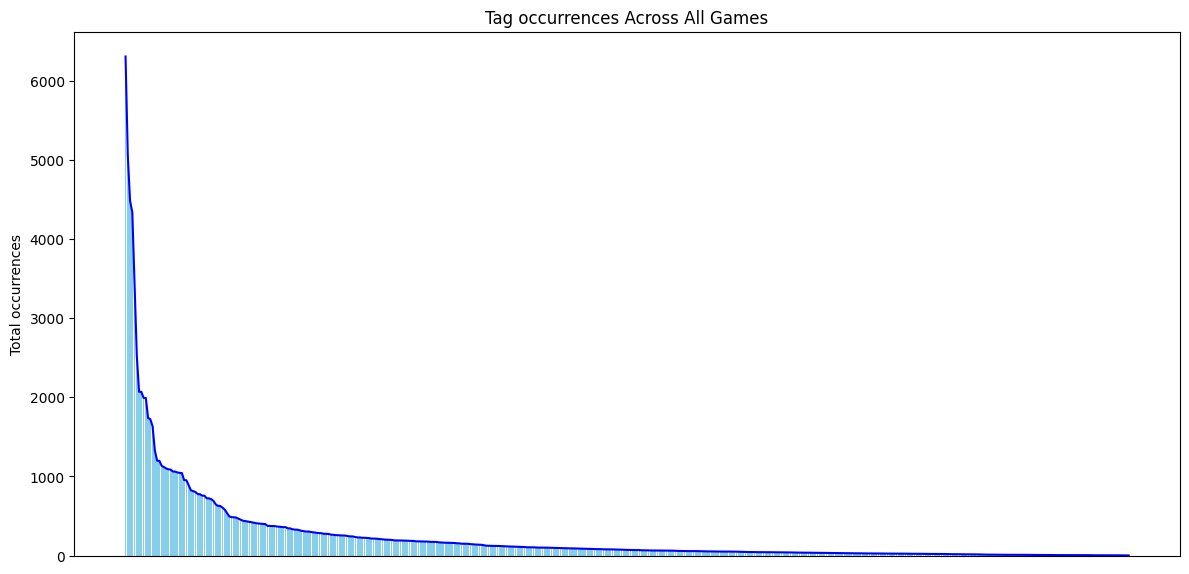

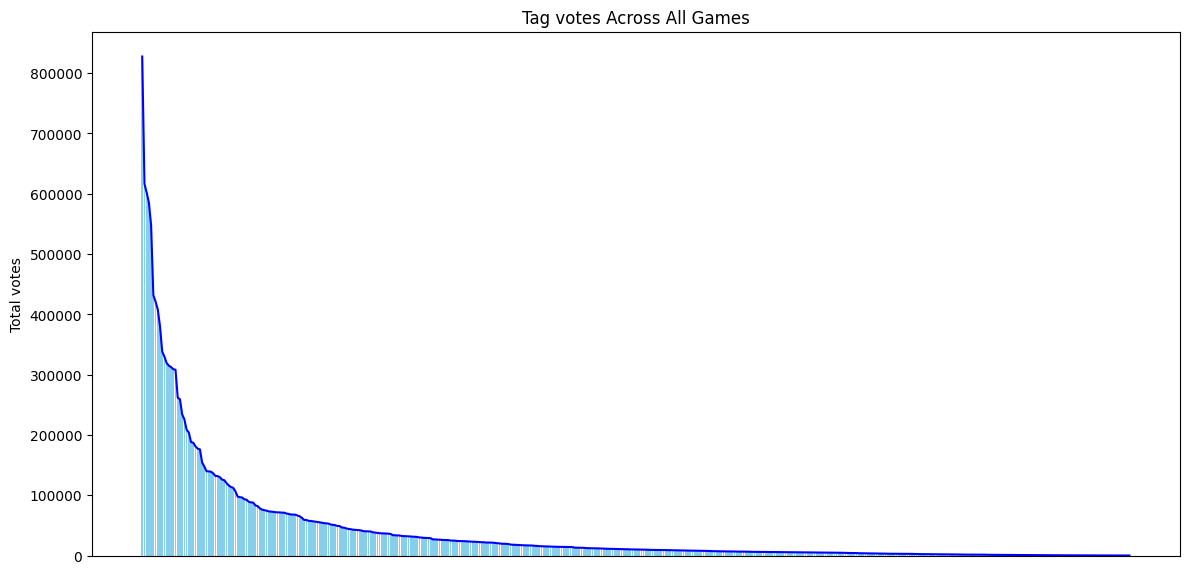

In [156]:

def visualize_tag_distribution_hist(tagCountsDF:pd.DataFrame, by="occurrences", line=True):
    tags = tagCountsDF.sort_values(by=by, ascending=False)

    plt.figure(figsize=(12, 6))

    if line:
        votes = np.array(tags[by])
        votes_sorted = np.sort(votes)[::-1]  # descending
        plt.plot(votes_sorted, color='blue')

    plt.bar(tags['tag'], tags[by], color='skyblue') 
    plt.ylabel(f"Total {by}")
    plt.title(f"Tag {by} Across All Games")
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.xticks([]) 
    plt.show()

visualize_tag_distribution_hist(tagCountsDF, by="occurrences")
visualize_tag_distribution_hist(tagCountsDF, by="votes")

### 3.2 Tag Similarity

(446,)


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 765acda9-dd82-42bc-aba8-ca4d336f5acc)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./config_sentence_transformers.json
Retrying in 1s [Retry 1/5].
Batches: 100%|██████████| 14/14 [00:00<00:00, 26.19it/s]


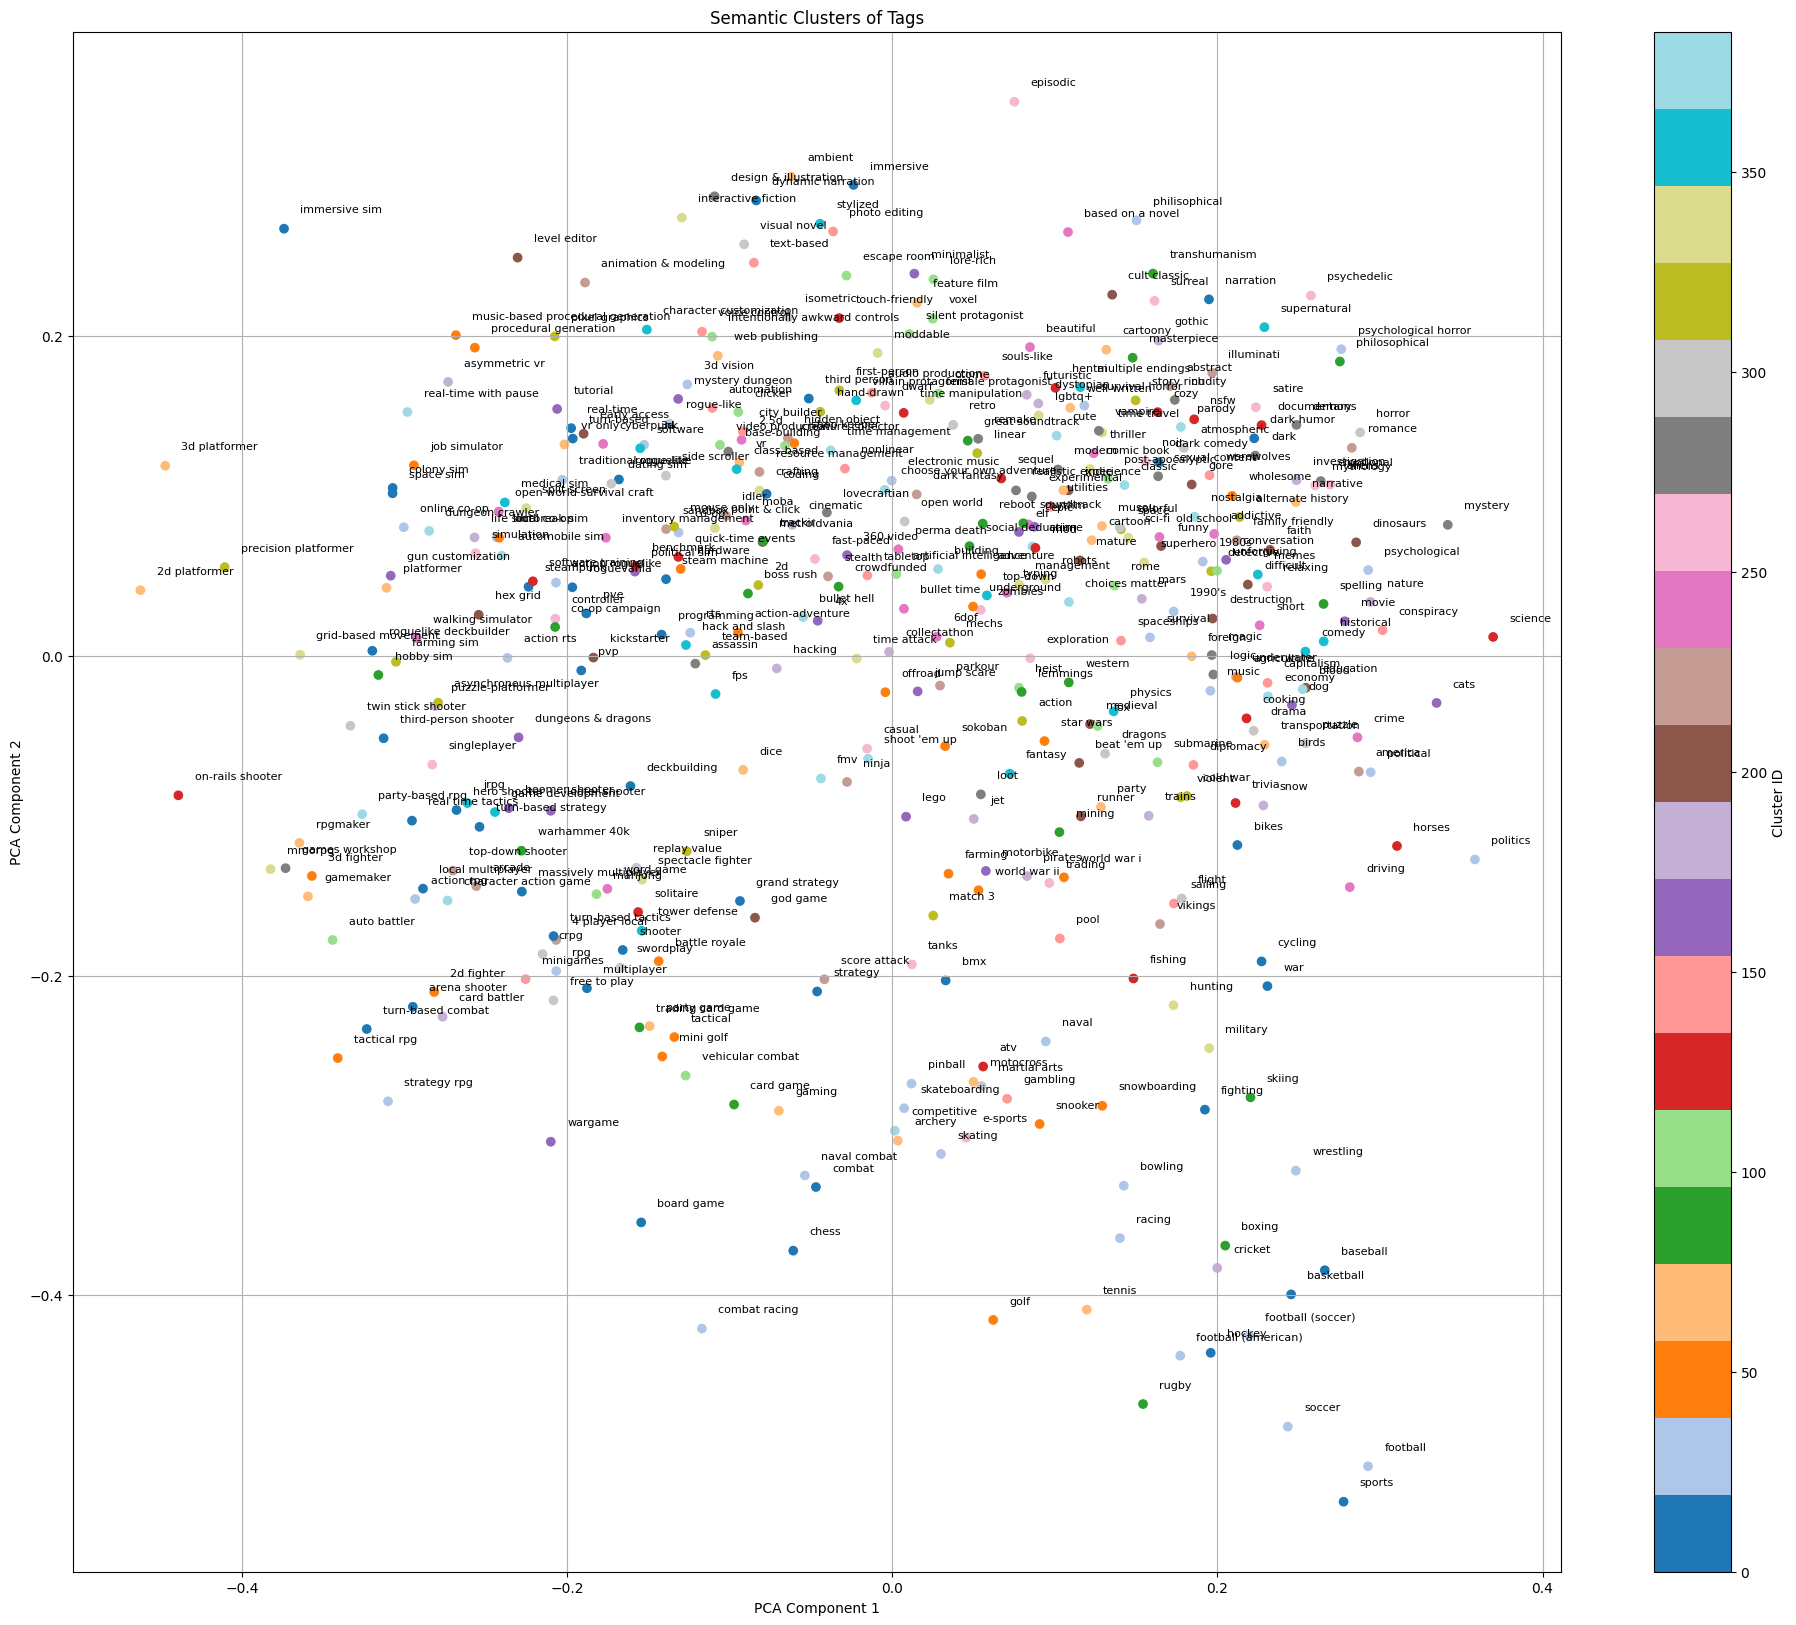

In [ ]:
def show_tag_similarity(tagCountsDF, printClusters=False):

    def print_clusters(tags, groups):
        # Group tags by their assigned cluster
        cluster_dict = defaultdict(list)
        for tag, cluster_id in zip(tags, groups):
            cluster_dict[cluster_id].append(tag)

        # Print each cluster and the tags inside
        for cluster_id, tag_list in sorted(cluster_dict.items(), key=lambda x: len(x[1]), reverse=True):
            tags_joined = ", ".join(tag_list)
            print(f"Cluster {cluster_id} ({len(tag_list)} tags): {tags_joined}")

    # tag_df = top_k_by_count(tag_df, 100)
    tags = np.array(tagCountsDF['tag'])
    print(tags.shape) # 446, 

    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(tags, show_progress_bar=True)

    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.3, metric='cosine', linkage='average')
    groups = clustering.fit_predict(embeddings)

    # Reduce embeddings to 2D for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    plt.figure(figsize=(24, 20))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=groups, cmap='tab20')

    for i, tag in enumerate(tags):
        plt.annotate(tag, (embeddings_2d[i, 0] + 0.01, embeddings_2d[i, 1] + 0.01), fontsize=8)

    plt.title("Semantic Clusters of Tags")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label='Cluster ID')
    plt.grid(True)
    plt.show()

    if printClusters:
        print_clusters(tags, groups)

show_tag_similarity(tagCountsDF)

# 4. Tag Co-Occurance

In [158]:
def filter_games_df(tagGamesDF: pd.DataFrame, tags: list):
    
    tags_set = set(tags)
    tags_array = tagGamesDF['tags'].to_numpy(dtype=object)

    filtered_tags = np.vectorize(lambda t_list: [t for t in t_list if t in tags_set], otypes=[object])(tags_array)
    
    result_df = pd.DataFrame({
        'APPID': tagGamesDF['APPID'],
        'tags': filtered_tags
    })
    
    return result_df


(9962, 2)


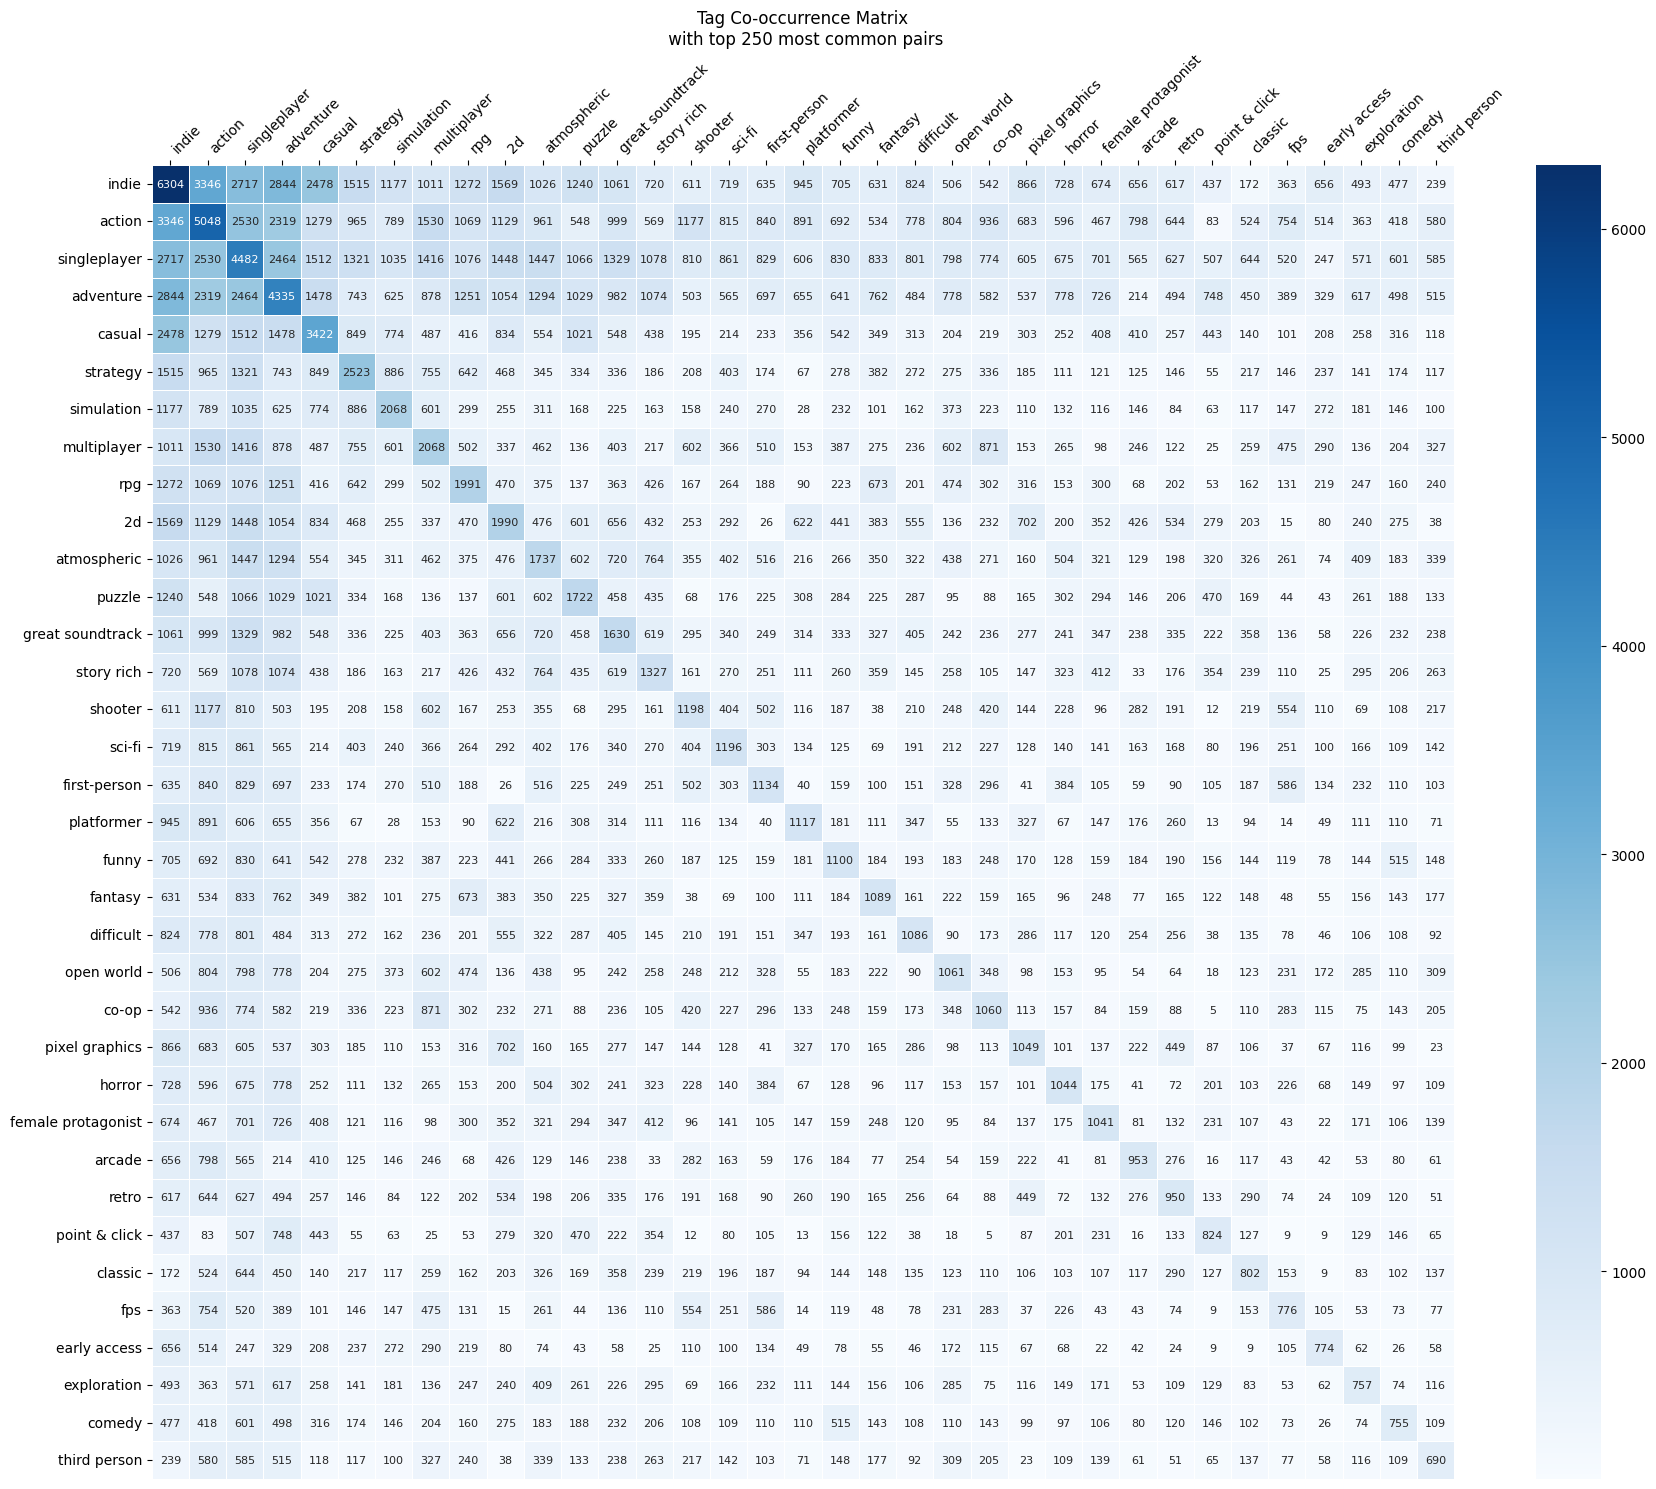

In [159]:
def compute_tag_cooccurrence(tagGamesDF, tagCountsDF, excludeTopOcc=None, top_n=None, top_k_pairs=None):
    """
    Computes the co-occurrence matrix of tags across games, with options to:
    - Exclude globally common tags,
    - Filter by top co-occurring tags,
    - OR extract tags involved in the strongest co-occurrence pairs.

    Args:
        tagGamesDF (pd.DataFrame): columns ['APPID', 'tags'], 'tags' is a list of tags per game
        tagCountsDF (pd.DataFrame): columns ['tag', 'occurences']
        excludeTopOcc (int, optional): exclude this many most frequent tags
        top_n (int, optional): keep top_n tags by total co-occurrence
        top_k_pairs (int, optional): keep tags involved in top_k_pairs strongest co-occurrences

    Returns:
        pd.DataFrame: square co-occurrence matrix
    """
    if excludeTopOcc:
        excluded_tags = set(tagCountsDF.nlargest(excludeTopOcc, 'occurrences')['tag'])
    else:
        excluded_tags = set()

    filtered_tags_list = tagGamesDF['tags'].apply(lambda tags: [t for t in tags if t not in excluded_tags])

    all_tags = sorted({t for tags in filtered_tags_list for t in tags})
    tag_index = {tag: i for i, tag in enumerate(all_tags)}
    n_tags = len(all_tags)

    co_matrix = np.zeros((n_tags, n_tags), dtype=int)
    for tags in filtered_tags_list:
        idx = [tag_index[t] for t in tags]
        for i in idx:
            for j in idx:
                co_matrix[i, j] += 1

    co_df = pd.DataFrame(co_matrix, index=all_tags, columns=all_tags)

    if top_n:
        tag_totals = co_df.sum(axis=1) - np.diag(co_matrix)
        top_tags = tag_totals.nlargest(top_n).index
        return co_df.loc[top_tags, top_tags]

    if top_k_pairs:
        # Remove diagonal to avoid picking self-relations
        co_no_diag = co_df.where(~np.eye(co_df.shape[0], dtype=bool), other=0)
        # Stack matrix to get (tag1, tag2, value) tuples, sort by co-occurrence
        strongest = co_no_diag.stack().sort_values(ascending=False).head(top_k_pairs)
        # Extract unique tags involved in those strong relationships
        selected_tags = set(strongest.index.get_level_values(0)).union(
                         strongest.index.get_level_values(1))
        return co_df.loc[list(selected_tags), list(selected_tags)]

    return co_df

def sort_cooccurrence_by_diagonal(co_df, ascending=False):
    """
    Sorts a co-occurrence matrix so that the largest diagonal values appear first.

    Args:
        co_df (pd.DataFrame): square co-occurrence matrix
        ascending (bool): sort order, False = largest first (default)

    Returns:
        pd.DataFrame: sorted co-occurrence matrix
    """
    diag_values = co_df.values.diagonal()
    order = np.argsort(diag_values) if ascending else np.argsort(-diag_values)
    sorted_labels = co_df.index[order]
    return co_df.loc[sorted_labels, sorted_labels]


def visualize_cooccurrence_matrix(co_df, figsize=(12, 10), title="Tag Co-occurrence Matrix", annot=True, fontsize=8):
    """
    Visualizes a co-occurrence matrix using a heatmap.

    Args:
        co_df (pd.DataFrame): square co-occurrence matrix
        figsize (tuple): figure size
        title (str): plot title
        annot (bool): show numeric values in cells
        fontsize (int): annotation font size
    """
    plt.figure(figsize=figsize)
    sns.heatmap(
        co_df,
        cmap="Blues",
        annot=annot,
        fmt="d",                     # integer formatting for counts
        annot_kws={"size": fontsize},
        cbar=True,
        linewidths=0.5
    )
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    plt.xticks(rotation=45, ha="left")
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()


K=250
print(tagGamesDF.shape) 
top_100 = tagCountsDF.sort_values(by="occurrences", ascending=False)['tag'][:100]
co_df = compute_tag_cooccurrence(tagGamesDF, tagCountsDF, top_k_pairs=K)
co_df = sort_cooccurrence_by_diagonal(co_df=co_df)
visualize_cooccurrence_matrix(co_df, figsize=(18, 15), title=f"Tag Co-occurrence Matrix\n with top {K} most common pairs")